In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


The  data  is  available  as  two  attached  CSV  files:

 - takehome_user_engagement. csv
 
 - takehome_users . csv
 
The  data  has  the  following  two  tables:

1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:

    ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
    ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
    ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    ○ SIGNUP:  signed  up  via  the  website
    ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google
    email  account  for  their  login id)

● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip

● org_id:   the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin1')
engage_df = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Check how many users and how many logins
print('{} users for a {} total logins'.format(
    engage_df['user_id'].nunique(), len(engage_df)
))

8823 users for a 207917 total logins


In [6]:
# Merge the DataFrames based on the "user_id" column using an inner join
df = pd.merge(engage_df, users_df, left_on="user_id", right_on="object_id", how="inner")

# Drop the redundant "object_id" column (since it's the same as "user_id")
df.drop("object_id", axis=1, inplace=True)


In [7]:
# Convert date columns to datetime objects
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'])

def identify_adopted_users(df):
    # Sort the DataFrame by 'user_id' and 'time_stamp' for consistent calculations
    df.sort_values(by=['user_id', 'time_stamp'], inplace=True)
    
    # Group by 'user_id' and calculate the time difference between consecutive logins
    df['time_diff'] = df.groupby('user_id')['time_stamp'].diff()
    
    # Define a function to check if a user has logged in on three separate days in a seven-day period
    def check_adopted(group):
        consecutive_days = 0
        for diff in group['time_diff']:
            if pd.notnull(diff) and diff <= pd.Timedelta(days=7):
                consecutive_days += 1
                if consecutive_days >= 3:
                    return 1  # User is adopted
            else:
                consecutive_days = 0
        return 0  # User is not adopted
    
    # Apply the check_adopted function to each user's login history
    adopted_users = df.groupby('user_id').apply(check_adopted)
    
    # Create a DataFrame with 'user_id' and 'adopted_user' columns
    adopted_users_df = pd.DataFrame({'user_id': adopted_users.index, 'adopted_user': adopted_users.values})
    
    return adopted_users_df

# Call the function to identify adopted users
adopted_users_df = identify_adopted_users(df)

# Merge the adopted user information back into the main DataFrame
df = pd.merge(df, adopted_users_df, on='user_id', how='left')

# Fill missing values (users who are not adopted) with 0
df['adopted_user'].fillna(0, inplace=True)


In [8]:
df.head(20)

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_diff,adopted_user
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,NaT,0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,NaT,1
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,14 days,1
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,10 days,1
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,16 days,1
5,2013-12-31 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,6 days,1
6,2014-01-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,8 days,1
7,2014-02-03 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,26 days,1
8,2014-02-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,5 days,1
9,2014-02-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,1 days,1


In [9]:
df.describe()

,user_id,visited,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_diff,adopted_user
count,207917.000000,207917.0,207917.000000,207917.000000,207917.000000,116887.000000,199094,207917.000000
mean,5913.314197,1.0,0.258137,0.154533,164.315895,5972.167555,2 days 13:55:18.717791595,0.951115
std,3394.941674,0.0,0.437611,0.361460,121.165846,3247.095621,4 days 00:34:02.123318669,0.215628
min,1.000000,1.0,0.000000,0.000000,0.000000,3.000000,1 days 00:00:00,0.000000
25%,3087.000000,1.0,0.000000,0.000000,60.000000,3269.000000,1 days 00:00:00,1.000000
50%,5682.000000,1.0,0.000000,0.000000,145.000000,5972.000000,1 days 00:00:00,1.000000
75%,8944.000000,1.0,1.000000,0.000000,260.000000,8513.000000,2 days 00:00:00,1.000000
max,12000.000000,1.0,1.000000,1.000000,416.000000,11999.000000,115 days 00:00:00,1.000000


In [10]:
# Check for NaN values in the entire DataFrame
nan_counts = df.isna().sum()

# Filter columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(columns_with_nan)


Columns with NaN values:
invited_by_user_id    91030
time_diff              8823
dtype: int64


After the above results, I looked at the raw data a little more in depth. I was able to discover that we need to drop duplicate information from users. Next, I was also able to see that the first instance of time_diff was showing as NaN. Once we understand whether a user is adopted user or not, that information is no longer needed, so we are able to drop the column. Lastly, we will explore where are the non invited users coming from, if they are organic and not invited by another user, we could simply make it 0 and understand that those users did not get an invite. 

In [11]:
# Remove duplicate rows based on the 'user_id' column, keeping the last instance
df = df.drop_duplicates(subset='user_id', keep='last')

# Reset the index of the DataFrame after removing duplicates
df = df.reset_index(drop=True)

In [12]:
# Remove the 'time_diff' column
df = df.drop('time_diff', axis=1)

In [13]:
df.visited.unique()

array([1], dtype=int64)

In [14]:
# Drop the 'visited' column as it seems to not include any real information. 
df.drop('visited', axis=1, inplace=True)

In [15]:
# Filter rows where 'invited_by_user_id' is missing (NaN)
nan_rows = df[df['invited_by_user_id'].isna()]

# Count the occurrences of each 'creation_source' value in these rows
creation_source_counts = nan_rows['creation_source'].value_counts()

# Display the distribution of 'creation_source' in rows with missing 'invited_by_user_id'
print("Distribution of 'creation_source' in rows with missing 'invited_by_user_id':")
print(creation_source_counts)


Distribution of 'creation_source' in rows with missing 'invited_by_user_id':
SIGNUP                1898
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64


In [16]:
# Check if there are any rows with 'invited_by_user_id' equal to 0
has_invited_by_user_id_zero = (df['invited_by_user_id'] == 0).any()

# Print the result
if has_invited_by_user_id_zero:
    print("There are rows with 'invited_by_user_id' equal to 0.")
else:
    print("There are no rows with 'invited_by_user_id' equal to 0.")


There are no rows with 'invited_by_user_id' equal to 0.


In [17]:
# Replace NaN values in 'invited_by_user_id' with 0
df['invited_by_user_id'].fillna(0, inplace=True)


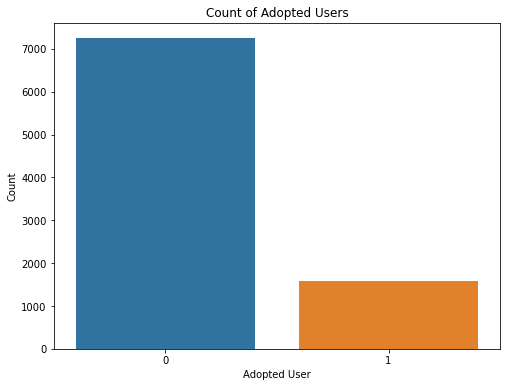

In [18]:
# Count of Adopted Users
plt.figure(figsize=(8, 6))
sns.countplot(x='adopted_user', data=df)
plt.title("Count of Adopted Users")
plt.xlabel("Adopted User")
plt.ylabel("Count")
plt.show()

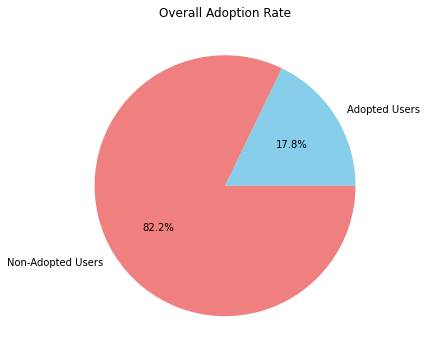

Overall Percentage of Adopted Users: 17.83%


In [19]:
# Calculate the overall percentage of adopted users
overall_percentage_adopted = (df['adopted_user'].sum() / len(df)) * 100

# Create a pie chart to visualize the overall adoption rate
plt.figure(figsize=(6, 6))
plt.pie([overall_percentage_adopted, 100 - overall_percentage_adopted], labels=['Adopted Users', 'Non-Adopted Users'],
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title("Overall Adoption Rate")
plt.show()

# Display the calculated overall percentage
print(f"Overall Percentage of Adopted Users: {overall_percentage_adopted:.2f}%")

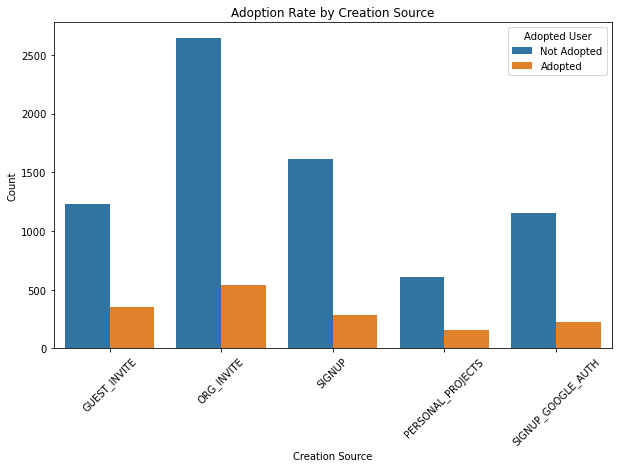

In [20]:
# Categorical Features (e.g., 'creation_source')
plt.figure(figsize=(10, 6))
sns.countplot(x='creation_source', hue='adopted_user', data=df)
plt.title("Adoption Rate by Creation Source")
plt.xlabel("Creation Source")
plt.ylabel("Count")
plt.legend(title="Adopted User", loc='upper right', labels=["Not Adopted", "Adopted"])
plt.xticks(rotation=45)
plt.show()


Intermediate Results:
creation_source
GUEST_INVITE          22.418136
ORG_INVITE            17.063990
PERSONAL_PROJECTS     20.680628
SIGNUP                15.121180
SIGNUP_GOOGLE_AUTH    16.462094
Name: adopted_user, dtype: float64


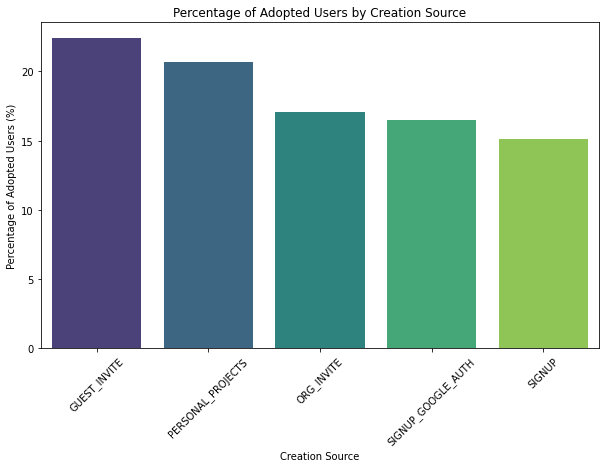

In [21]:
# Let's look at the creation source but in percentages. 
# Calculate the percentage of adopted users in each 'creation_source' category
percentage_adopted_by_creation_source = df.groupby('creation_source')['adopted_user'].mean() * 100

# Print intermediate results for debugging
print("Intermediate Results:")
print(percentage_adopted_by_creation_source)

# Sort the values for better visualization
percentage_adopted_by_creation_source = percentage_adopted_by_creation_source.sort_values(ascending=False)

# Create a bar plot to show the percentage of adopted users by 'creation_source'
plt.figure(figsize=(10, 6))
sns.barplot(x=percentage_adopted_by_creation_source.index, y=percentage_adopted_by_creation_source.values, palette="viridis")
plt.title("Percentage of Adopted Users by Creation Source")
plt.xlabel("Creation Source")
plt.ylabel("Percentage of Adopted Users (%)")
plt.xticks(rotation=45)
plt.show()


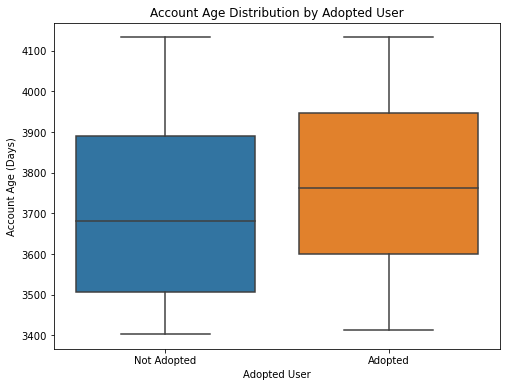

In [22]:
# Calculate user account age in days
df['account_age_days'] = (datetime.datetime.now() - df['creation_time']).dt.days
# Numerical Features (account_age_days)
plt.figure(figsize=(8, 6))
sns.boxplot(x='adopted_user', y='account_age_days', data=df)
plt.title("Account Age Distribution by Adopted User")
plt.xlabel("Adopted User")
plt.ylabel("Account Age (Days)")
plt.xticks([0, 1], ["Not Adopted", "Adopted"])
plt.show()


I think this is an important feature we would like to continut to explore later on. 


From above, we have learn that old accounts tend to have a higher adoption rate. 

In [23]:
# Create separate binary columns for each 'creation_source' category
df['PERSONAL_PROJECTS'] = (df['creation_source'] == 'PERSONAL_PROJECTS').astype(int)
df['GUEST_INVITE'] = (df['creation_source'] == 'GUEST_INVITE').astype(int)
df['ORG_INVITE'] = (df['creation_source'] == 'ORG_INVITE').astype(int)
df['SIGNUP'] = (df['creation_source'] == 'SIGNUP').astype(int)
df['SIGNUP_GOOGLE_AUTH'] = (df['creation_source'] == 'SIGNUP_GOOGLE_AUTH').astype(int)

# Drop the original 'creation_source' column if needed
# df.drop('creation_source', axis=1, inplace=True)

In [24]:
df.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))


opted_in_to_mailing_list
0    0.176444
1    0.183738
Name: adopted_user, dtype: float64

Not a big difference in adoption rate if they opted into mailing list. However, if opted in, there is a slight increase in the chance that you will be adopted. 

In [25]:
df['invited_by_user'] = (df['invited_by_user_id'] != 0).astype(int)


In [26]:
df.groupby('invited_by_user')['adopted_user'].apply(lambda x: sum(x)/len(x))


invited_by_user
0    0.166296
1    0.188442
Name: adopted_user, dtype: float64

Not a huge difference in adoption rate if they were invited by other users though a noticeable one. 

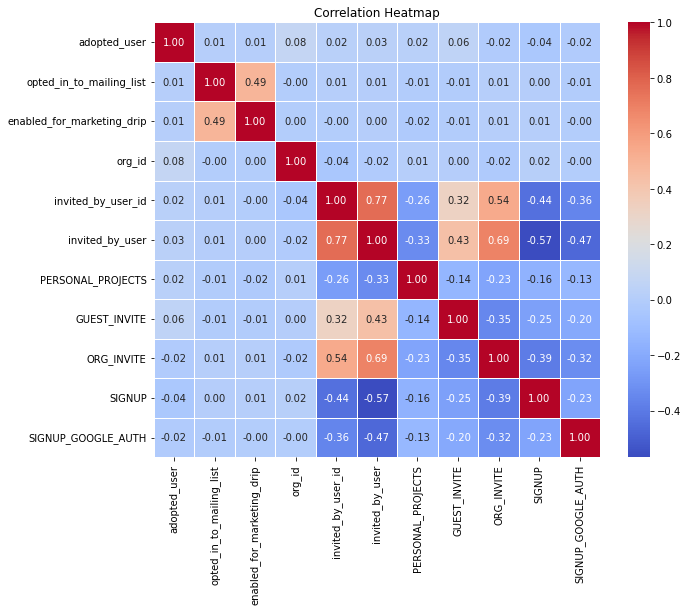

In [27]:
# Heatmap
numerical_columns = ['adopted_user', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'invited_by_user', 'PERSONAL_PROJECTS',  'GUEST_INVITE', 'ORG_INVITE',  'SIGNUP',  'SIGNUP_GOOGLE_AUTH']
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


Predictive Modeling

In [28]:
# Let's explore the relevance of age of account.
df['account_age_days'] = (datetime.datetime.now() - df['creation_time']).dt.days

# Drop 'creation_time', 'time_stamp', and 'last_session_creation_time' columns
df.drop(['creation_time', 'time_stamp', 'last_session_creation_time'], axis=1, inplace=True)

# Drop 'name' and 'email'
df.drop(['name', 'email'], axis=1, inplace=True)


In [29]:
df.head()

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,account_age_days,PERSONAL_PROJECTS,GUEST_INVITE,ORG_INVITE,SIGNUP,SIGNUP_GOOGLE_AUTH,invited_by_user
0,1,GUEST_INVITE,1,0,11,10803.0,0,3442,0,1,0,0,0,1
1,2,ORG_INVITE,0,0,1,316.0,1,3600,0,0,1,0,0,1
2,3,ORG_INVITE,0,0,94,1525.0,0,3840,0,0,1,0,0,1
3,4,GUEST_INVITE,0,0,1,5151.0,0,3778,0,1,0,0,0,1
4,5,GUEST_INVITE,0,0,193,5240.0,0,3902,0,1,0,0,0,1


In [39]:
from sklearn.model_selection import train_test_split

numerical_columns = ['adopted_user', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user', 'account_age_days', 'PERSONAL_PROJECTS',  'GUEST_INVITE', 'ORG_INVITE',  'SIGNUP',  'SIGNUP_GOOGLE_AUTH']

# Define your features (X) and target variable (y)
X = df[numerical_columns[1:]]  # Features (excluding 'adopted_user')
y = df['adopted_user']  # Target variable

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for model training and evaluation


In [40]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)


In [41]:
# Train the model on the training data
model.fit(X_train, y_train)


LogisticRegression(random_state=42)

Accuracy: 0.814884775217227
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      2157
           1       0.00      0.00      0.00       490

    accuracy                           0.81      2647
   macro avg       0.41      0.50      0.45      2647
weighted avg       0.66      0.81      0.73      2647



C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


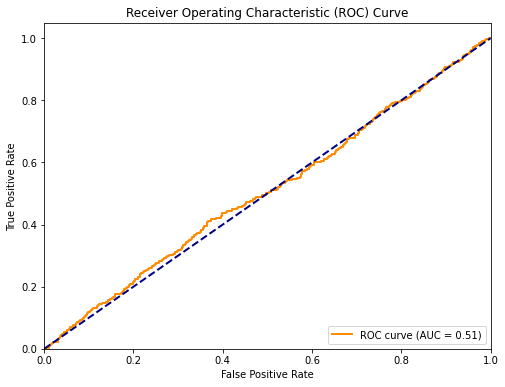

In [43]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC curve and AUC
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The accuracy is high, primarily because the model is correctly predicting class 0 (not adopted users) due to the class imbalance. However, it's clear that the model struggles to correctly predict class 1 (adopted users) as indicated by the low precision, recall, and F1-score for class 1. We should try a different model.

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable on the testing data
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Generate a classification report
rf_class_report = classification_report(y_test, rf_y_pred)
print("Random Forest Classification Report:\n", rf_class_report)


Random Forest Accuracy: 0.7842840952021156
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.88      2157
           1       0.30      0.12      0.17       490

    accuracy                           0.78      2647
   macro avg       0.56      0.53      0.52      2647
weighted avg       0.73      0.78      0.75      2647



Still not a great predicter for adopted users. 

In [45]:
data = df[['creation_source']]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Perform one-hot encoding on the 'creation_source' column
creation_source_encoded = encoder.fit_transform(data)

# Get the category names from the encoder
categories = encoder.get_feature_names_out(['creation_source'])

# Create a DataFrame with one-hot encoded columns and column names
encoded_df = pd.DataFrame(creation_source_encoded, columns=categories)

# Now, 'encoded_df' contains the one-hot encoded 'creation_source' values


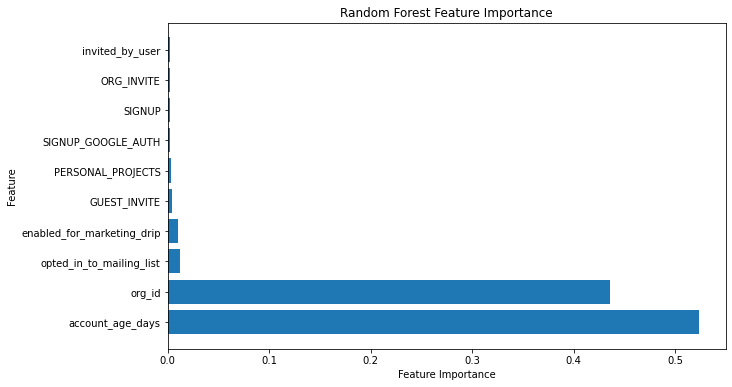

In [46]:
# Assuming 'X' is your feature matrix and 'y' is your target variable
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_


# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


From the Random Forest Classifier we are able to see that org_id and account_age_days play a huge part in whether a user will become an adopted user. 

In [47]:
# Create dummy variables for the 'creation_source' column
creation_source = pd.get_dummies(df['creation_source'], drop_first=True)

# Concatenate the dummy variables with the original DataFrame and drop the original 'creation_source' column
model_data = pd.concat([df, creation_source], axis=1).drop('creation_source', axis=1)

# Define the target variable 'y' and the feature matrix 'X'
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

# Split the data into training and testing sets, ensuring stratification
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [48]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(Xtrain, ytrain)

# Make predictions on the testing data
ypred = rf_model.predict(Xtest)

# Evaluate model performance
accuracy = accuracy_score(ytest, ypred)
classification_rep = classification_report(ytest, ypred)

# Print model performance metrics
print(f'Random Forest Accuracy: {accuracy:.2f}')
print('Random Forest Classification Report:\n', classification_rep)

Random Forest Accuracy: 0.80
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1813
           1       0.15      0.02      0.04       393

    accuracy                           0.80      2206
   macro avg       0.49      0.50      0.47      2206
weighted avg       0.70      0.80      0.74      2206



In [49]:
# use random forest model with balanced class weights to correct for imbalance in the data
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.8163828203318925


In [50]:
# evaluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=200
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.8082502266545785
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1813
           1       0.22      0.03      0.05       393

    accuracy                           0.81      2206
   macro avg       0.52      0.50      0.47      2206
weighted avg       0.72      0.81      0.74      2206



In [51]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

account_age_days              0.307960
user_id                       0.257103
org_id                        0.247336
invited_by_user_id            0.126879
opted_in_to_mailing_list      0.017585
enabled_for_marketing_drip    0.014812
GUEST_INVITE                  0.004629
ORG_INVITE                    0.003464
ORG_INVITE                    0.003237
SIGNUP                        0.002669
SIGNUP_GOOGLE_AUTH            0.002560
SIGNUP                        0.002533
SIGNUP_GOOGLE_AUTH            0.002495
invited_by_user               0.002374
PERSONAL_PROJECTS             0.002244
PERSONAL_PROJECTS             0.002121
dtype: float64


It is clear that the most important feature is account_age_days and org_id. It is recommended that the company focus on that. What could be done is provide incentives to get people to sign up, down the line, the more accounts we have and the longer users have had an account, the more adopted users we will get. Next, org_id is a big factor too. That tells us that if we can agressively pursue institutional users through companies, that would be good for obtaining adopted users. Also noteworthy, looking at creation source, guest invite and personal project are amongt the top of adopted users. 